# Breaking workflows 
Applying MS false peptide match logic to my workflows to show that, despite the fact that a high number of citations is the best predictor of highly rated workflow, it does not contain any co-usage information and is therefore not a good metric. 

In [1]:
import json
import sys
import os
import matplotlib.pyplot as plt 
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import nest_asyncio
nest_asyncio.apply()
import asyncio
import json
import pubmetric.network as nw
from scipy.stats import ttest_rel
import numpy as np 
from pubmetric.metrics import connectivity, citations 
from pubmetric import pckg_dev as dev


The aim is to infer functional relationships based on citation patterns. The underlying assumption is that tools used together in a workflow are likely to be cited together in research papers. Additionally, tools with similar functions may also frequently appear together in citations. The most straightforward metric for evaluating a functional workflow is by identifying which tool has the most citations.

I plan to create a reverse dataset because I believe that examining the number of co-citations of tools provides more insight into their co-usage. The correlation between citation counts and high ratings may be influenced by confounding factors, such as the frequent use of highly cited tools. However, this does not necessarily indicate that these tools are often used together.

To test this, I will compile a list of the top 100 most cited tools and then disrupt well-performing workflows by randomly replacing one tool with one from this top 100 list. This approach aims to demonstrate that a good metric should meet certain criteria: 

1. If all connections (edges) represent viable, functional, and actually used tool combinations, the metric should yield a high score.
2. If an edge is replaced with a better one, the metric score should increase, and vice versa.

I hope to show that the connectivity between tools in a graph more accurately reflects the true functional relationships between tools, although the rated dataset correlates more just to the number of citations a tool has.

In [2]:
path_to_data = '../out_20240801231111' 
loaded_graph = asyncio.run(nw.create_citation_network(inpath=path_to_data, load_graph=True))

2024-08-06 14:52:11 - Graph loaded from ../out_20240801231111


In [14]:
citation_counts = {tool['name']: tool['nr_citations'] for tool in loaded_graph.vs}
citation_values = list(citation_counts.values())

sorted_citation_counts = dict(sorted(citation_counts.items(), key=lambda item: item[1], reverse=True))
top_citation_counts = list(sorted_citation_counts.values())[0:100]


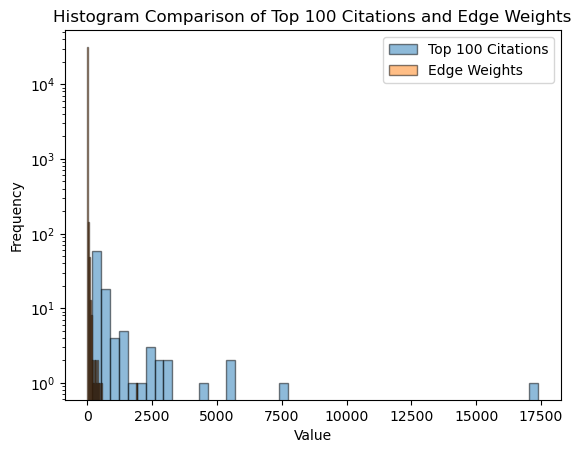

In [15]:
edge_weights = loaded_graph.es['weight']

# Plot histograms for top 100 citation counts and edge weights to ensure they are smaller than the citation counts 
plt.hist(top_citation_counts, bins=50, alpha=0.5, label='Top 100 Citations', edgecolor='black')
plt.hist(edge_weights, bins=50, alpha=0.5, label='Edge Weights', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram Comparison of Top 100 Citations and Edge Weights')
plt.legend(loc='upper right')
plt.show()


### breaking workflows


In [5]:
with open('../data/train_rated.json', 'r') as f:
    rated_workflows = json.load(f)
print(len(rated_workflows))
highly_rated_workflows = [workflow["pmid_workflow"] for workflow in rated_workflows if workflow['ratingAvg'] >= 2] # this means that at least one of them gave it a two or higher
print(len(highly_rated_workflows))


In [9]:
all_scores = []
for workflow in highly_rated_workflows:
    workflow = dev.convert_to_tuples(workflow)
    if not workflow:
        continue
    # Original scores:
    og_connectivity_score = connectivity(loaded_graph, workflow)
    og_cite_score = median_citations(loaded_graph, workflow)

    broken_workflow = dev.break_workflow(workflow, top_citation_counts)

    # Scores after breaking the workflow
    broken_connectivity_score = connectivity(loaded_graph, broken_workflow)
    broken_cite_score = median_citations(loaded_graph, broken_workflow)

    all_scores.append({
        'original connectivity score': og_connectivity_score,
        'original citation score': og_cite_score,
        'broken connectivity score': broken_connectivity_score,
        'broken citation score': broken_cite_score
    })


In [11]:
# do testing that the breaking is functional and correct !! TODO plot things 

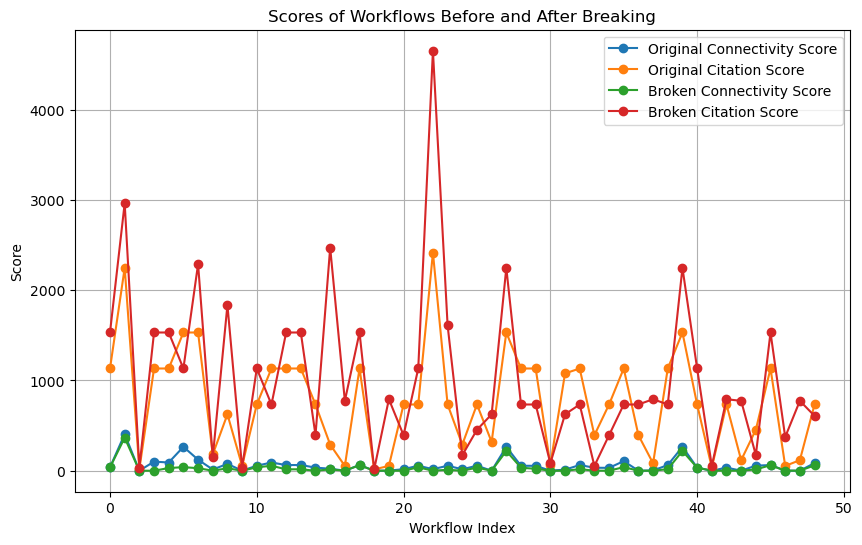

In [10]:
original_connectivity_scores = [score['original connectivity score'] for score in all_scores]
original_citation_scores = [score['original citation score'] for score in all_scores]
broken_connectivity_scores = [score['broken connectivity score'] for score in all_scores]
broken_citation_scores = [score['broken citation score'] for score in all_scores]

plt.figure(figsize=(10, 6))

plt.plot(original_connectivity_scores, label='Original Connectivity Score', marker='o')
plt.plot(original_citation_scores, label='Original Citation Score', marker='o')
plt.plot(broken_connectivity_scores, label='Broken Connectivity Score', marker='o')
plt.plot(broken_citation_scores, label='Broken Citation Score', marker='o')

plt.xlabel('Workflow Index')
plt.ylabel('Score')
plt.title('Scores of Workflows Before and After Breaking')
plt.legend()
plt.grid(True)
plt.show()

In [11]:

t_stat, p_value = ttest_rel(original_connectivity_scores, broken_connectivity_scores)
print(t_stat, p_value )

alpha = 0.05  
if p_value < alpha and np.mean(original_connectivity_scores) > np.mean(broken_connectivity_scores):
    print("It is probable that the original connectivity scores are significantly higher than the broken connectivity scores.")
else:
    print("There is no significant evidence that the original connectivity scores are higher than the broken connectivity scores.")

print(f"t-statistic: {t_stat}, p-value: {p_value}")

t_stat, p_value = ttest_rel(original_citation_scores, broken_citation_scores)

alpha = 0.05 
if p_value < alpha and np.mean(original_citation_scores) > np.mean(broken_citation_scores):
    print("It is probable that the original citation scores are significantly higher than the broken citation scores.")
else:
    print("There is no significant evidence that the original citation scores are higher than the broken citation scores.")

print(f"t-statistic: {t_stat}, p-value: {p_value}")

5.280487087361025 3.0819216975275198e-06
It is probable that the original connectivity scores are significantly higher than the broken connectivity scores.
t-statistic: 5.280487087361025, p-value: 3.0819216975275198e-06
There is no significant evidence that the original citation scores are higher than the broken citation scores.
t-statistic: -2.9811588804736653, p-value: 0.004499088169754183


Generate random workflow requires the new format. Update needed below 

In [ ]:

# I will now create randomm workflows with the same strructure as the original ones, using only the top 100 tools

higly_ranked_workflow_scores = []
random_workflow_scores = []
citations_higly_ranked_workflow_scores = []
citations_random_workflow_scores = []

for workflow in highly_rated_workflows:
    workflow = dev.convert_to_tuples(workflow)
    if not workflow:
        continue
    
    random_workflow = dev.generate_random_workflow(loaded_graph, workflow, tool_list=top_citation_counts, retain_degree=False)


    higly_ranked_workflow_scores.append( connectivity(loaded_graph, workflow) )
    random_workflow_scores.append( connectivity(loaded_graph, random_workflow) )

    citations_higly_ranked_workflow_scores.append( median_citations(loaded_graph, workflow) )
    citations_random_workflow_scores.append( median_citations(loaded_graph, random_workflow) )


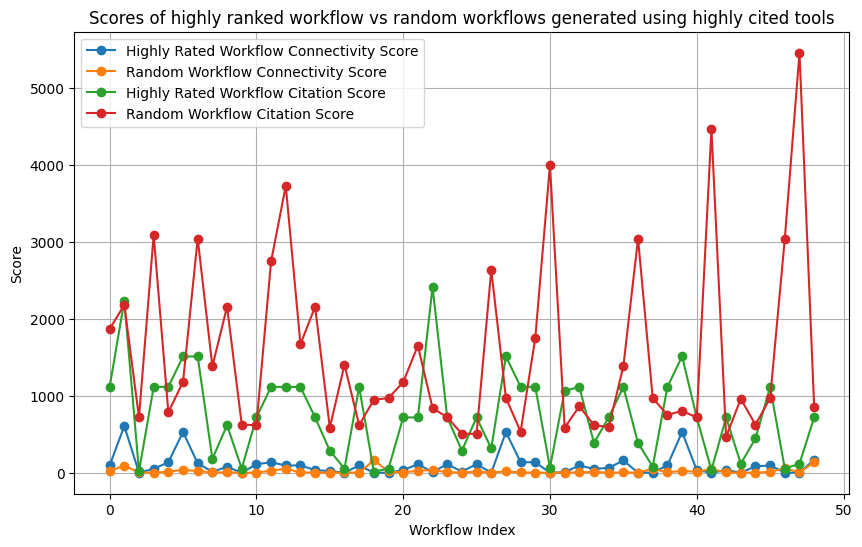

In [15]:

plt.figure(figsize=(10, 6))

plt.plot(higly_ranked_workflow_scores, label='Highly Rated Workflow Connectivity Score', marker='o')
plt.plot(random_workflow_scores, label='Random Workflow Connectivity Score', marker='o')
plt.plot(citations_higly_ranked_workflow_scores, label='Highly Rated Workflow Citation Score', marker='o')
plt.plot(citations_random_workflow_scores, label='Random Workflow Citation Score', marker='o')

plt.xlabel('Workflow Index')
plt.ylabel('Score')
plt.title('Scores of highly ranked workflow vs random workflows generated using highly cited tools')
plt.legend()
plt.grid(True)
plt.show()

In [16]:

t_stat, p_value = ttest_rel(higly_ranked_workflow_scores, random_workflow_scores)
print(t_stat, p_value )

alpha = 0.05  
if p_value < alpha and np.mean(original_connectivity_scores) > np.mean(broken_connectivity_scores):
    print("It is probable that the original connectivity scores are significantly higher than the random workflow connectivity scores.")
else:
    print("There is no significant evidence that the original connectivity scores are higher than the random workflow connectivity scores.")

print(f"t-statistic: {t_stat}, p-value: {p_value}")

t_stat, p_value = ttest_rel(citations_higly_ranked_workflow_scores, citations_random_workflow_scores)

alpha = 0.05 
if p_value < alpha and np.mean(original_citation_scores) > np.mean(broken_citation_scores):
    print("It is probable that the original citation scores are significantly higher than the random workflow citation scores.")
else:
    print("There is no significant evidence that the original citation scores are higher than the random workflow citation scores.")

print(f"t-statistic: {t_stat}, p-value: {p_value}")

3.9066429573659436 0.0002925073215740937
It is probable that the original connectivity scores are significantly higher than the random workflow connectivity scores.
t-statistic: 3.9066429573659436, p-value: 0.0002925073215740937
There is no significant evidence that the original citation scores are higher than the random workflow citation scores.
t-statistic: -3.9480576792924165, p-value: 0.00025683845504330665
